# Land Classifcaton Algorithms
An evaluation of land classification algorthims using various machine learning techniques. Comparing time and space efficiency, accuracy to known software results, and conducting statistical tests. 

## 1. Introduction

Satellite remote sensing of the earth is an effective way to gather data over a large surface area. This data can be used for various assessments, such as determining the vegetative health of  a region, the richness of the soil, or the composition of the landscape. Land classification models discern which areas within a scene belong to which land cover type; such as, coniferous vegetation, deciduous vegetation, wetlands, water bodies, urban areas, agriculture, grasslands, or desert. This can then be used for land development, natural resource management, and impact assessment studies [1]. These land classification algorithms help to turn satellite imagery into a tangible product which can then be compared to other data. As sensors become more spectrally and spatially refined, more accurate and detailed accounts for land cover are possible. Geographers are starting to take a ‘hands off’ approach to analyses and trust in computing power to derive their products. Machine learning and artificial intelligence is emerging as a large player in perfecting models for geography analyses. This study will compare probabilistic, support vector machine, and neural network models. As there are many avenues which have been explored, and many different models to compare to, this study will determine if the same results replicable.

This study assumes that the intended audience as a general understanding or knowledge of geographical and remote sensing terms and processes. 

In [1]:
# Bring in required libraries
import numpy as np
#import cv2
import matplotlib.pyplot as plt

# Import gdal
from osgeo import gdal
import time

# Import machine learning algorithms
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import cross_validate, cross_val_score, ShuffleSplit, StratifiedKFold

## 2. Data and Methods
### 2.1 Study Area 

The study area is the southern tip of Vancouver Island which includes the city of Victoria and the Saanich Penninsula (Fig. 1). It was chosen because it has a complex heterogenous landscape and very little snow cover. It contains various agriculture, urban, and water based landscapes which lends to a more difficult and interesting classification. The study area was chosen due to availability of expert knowledge of the landscape to collect a sample set. 

NEED MORE about the literature of the area and what has been studied here.

This study will consider seven land classes similar to --this paper-- []. As the likelihood of snow or ice in the mild Vancouver Island climate is quite low the forest/shrub class will be divided. 

|Land Class     |ID|
|---------------|--|
|Urban or Barren|1 | 
|Forest         |2 |
|Shrub          |3 |
|Agriculture    |4 |
|Grassland      |5 |
|Wetland        |6 |
|Water          |7 |


### 2.2 Data

Remote sensing data was made courtesy of the European Space Agency (ESA) and was collected using the Sentinel 2A mission on September 28, 2018. ESA is at the forefront of the open source data trend as all the data collect from the satellite missions it conducts are available to the general public. This is done to foster the growth of knowledge and pursuit of scientific discovery. ESA is known for deliverying quality products at high spatial and temporal resolution with three different sensors on two satellite missions: Sentinel 1, Sentinel 2A and Sentinel 2B (-- check for other missions ---). Sentinel 2A is a sensor which was designed for data collection over a terrestrial landscape for this reason it has varying spatial resolution of either 10 metres, 20 metres, or 60 metres depending on which spectral band is being considered (Table 1). Sentinel 2A data was considered due to the open source initiative and high spatial resolution which lends to more detailed land classifications. 

Specifically the remote sensing image attained has a latitude and longitude of the centre of the tile is 48°15’27.01”N and 123°36’29.39”W respectively. As cloud cover can -- what does it do other than get in the way?? --, the data attained on September 28, 2018 was chosen due to its clarity. Furthermore, data attained during this season will have a larger variety of vegetation when compared to the winter season. 

Table 1: Sentinel 2A Spectral Bands and Resolution where NIR is near infrared, MIR is mid infrared, VNIR is vegetation near infrared (red edge spectral domain), and SWIR is short wave infrared.

|Band Number|Type  |Central Wavelength (nm)|Bandwidth (nm)|Resolution (m)|
|-----------|------|-----------------------|--------------|--------------|
|   1       |Violet| 442.7                 | 27           | 60           |
|   2       |Blue  | 492.4                 | 98           | 10           |
|   3       |Green | 599.8                 | 45           | 10           |
|   4       |Red   | 664.6                 | 38           | 10           |
|   5       |VNIR  | 704.5                 | 19           | 20           |
|   6       |VNIR  | 740.5                 | 18           | 20           |
|   7       |VNIR  | 782.8                 | 28           | 20           |
|   8       |NIR   | 832.8                 | 145          | 10           |
|   8a      |VNIR  | 864.7                 | 33           | 20           |
|   9       |MIR   | 945.1                 | 26           | 60           |
|   10      |MIR   | 1373.5                | 75           | 60           |
|   11      |SWIR  | 1613.7                | 143          | 20           |
|   12      |SWIR  | 2202.4                | 242          | 20           |

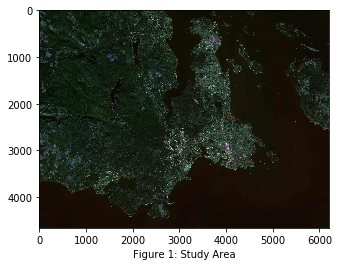

In [2]:
#load and display the data

# Set paths to GeoTiff and figures
tif_path = 'C:\\Users\\andre\\Documents\\UVIC\\ResearchProject\\Working\\S2A_0928\\'
#tif_path = 'H:\\ResearchProject\\Working\\S2A_0928\\'
#fig_path = 'C:\\Users\\andre\\Documents\\UVIC\\ResearchProject\\Working\\Figures\\'

# Open GeoTiff file
dataset = gdal.Open(tif_path+'S2A_0928_MLE_whole.tif', gdal.GA_ReadOnly)

# Display RGB image with bands 4,3,2 respectively
options_list = ['-ot Byte','-of JPEG', '-b 2', '-b 3', '-b 4', '-scale_2', '-scale_3','-scale_4' ] 
options_string = " ".join(options_list)

gdal.Translate(tif_path+'study_area.jpg', tif_path+'S2A_0928_MLE_whole.tif', options=options_string)
img = plt.imread(tif_path+'study_area.jpg')

plt.figure(1)#,figsize=(12,12))
plt.xlabel('Figure 1: Study Area')
plt.imshow(img*3) #Brighten image with scalar multiplication

In [3]:
# Save each band from dataset in a 3D array
S2_array = np.zeros((1,1,1))
#print('Descriptive statistics for each band')
stats_all = np.empty([4])
for x in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(x)
    array = band.ReadAsArray()
    if x <= 1:
        S2_array = np.array(array)
    else:
        S2_array = np.dstack((S2_array, np.array(array)))
   
    # Save statistics for each band
    stats = band.GetStatistics(True,True)
    stats_all = np.vstack((stats_all,stats))
    
data_bands = dataset.RasterCount
num_bands = data_bands - 2
print('Shape of Dataset')
print(S2_array.shape)
print('Number of bands')
print(data_bands)

Shape of Dataset
(4657, 6205, 13)
Number of bands
13


#### 2.2.1 Data Preprocessing
The remote sensing product was delivered by ESA as a level 1C product which is the top of the atmosphere (TOA) spectral returns which means that the atmospheric moisture (-- other atmospheric issues??--) persist. Therefore, the data required preprocessing using an atmospheric correction algorithm to return the bottom of the atmosphere (BOA) spectral returns. Typically, the data product contains metadata and atmospherical data required for this correction and there are many software packages which could be used to correct this product. The Sen2Cor atmospheric correction provided by ESA was used to correct atmospheric anomolies. It takes information from ... (use the points below)

- AOT - aerosol optical thickness
- WV - water vapor
- Look_UP_Tables selection of the configuration file, three entries: Aerosol_Type, Mid_Latitude and Ozone_Content can be set. The water vapour columns are set internally.
- Haze and cirrus cloud removal (low altitude haze)

As the study area will consist of the Saanich Peninsula and forested regions to the west. Therefore, the orginal tile was trimmed from -- square km -- to --square km --- before processing (Fig.1). A spectral subset was also done to remove bands 11 and 12 from the final product because they are used to perform the atmospheric correction, but are less determinant in land classification. While subsetting the data, spatially and spectrally, to match the 10m resolution the other bands were downsampled to match. The spectral returns for the bands which are 20m and 60m resolution are less important than bands 2, 3, 4, and 8 in the classification of land use. As these bands are within the optical part of the electromagnetic spectrum they interact greatly with the terrestiral features being considered (Fig.2). For example, vegetation interacts heavily with the green, red, and near-infrared parts of the spectrum and water interacts with the near-infrared band.

With the use of expert knowledge of the study area homogenous samples were taken for each class. In some cases finding homogenous samples was difficult which leads to an imbalance in the number of pixels collected for each class (Fig.3). In the case of water there are many water bodies clearly visible throughout the scene which are obviously homogenous, so larger sample polygons where created. In the case of grassland, shrub and wet land there were no large homogenous sample to find which lead to a smaller number of pixels chosen. Each land classification type has a unique spectral signature which allows the algorithm to determine which class it belongs to (Fig. 4). 

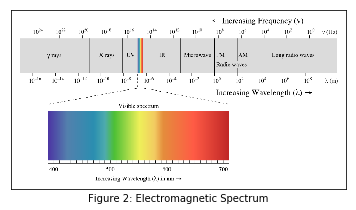

In [4]:
img_spec = plt.imread(tif_path+'EM_spectrum.png')
plt.figure(2)#, figsize=(14,12))
plt.xlabel('Figure 2: Electromagnetic Spectrum')
plt.xticks([])
plt.yticks([])
plt.imshow(img_spec)

The training data include 7 classes: [1 2 3 4 5 6 7]
Class ID 1: Urban
Class ID 2: Forest
Class ID 3: Shrub
Class ID 4: Agriculture
Class ID 5: Grassland
Class ID 6: Wetland
Class ID 7: Water


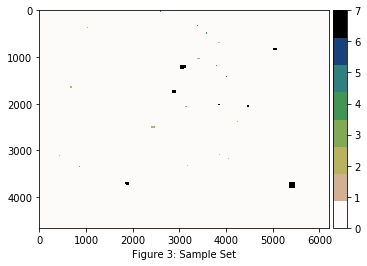

In [5]:
# Extract classification labels from dataset
#!!!CHANGE COLOURS AND SIZE
import matplotlib.colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
sites = S2_array[:,:,11]
S2_image = S2_array[:,:,0:11]
MLE_image = S2_array[:,:,12]
l,w = sites.shape
labels_ID,counts = np.unique(sites[sites>0], return_counts = True)
print('The training data include %d classes: %s'%(labels_ID.size, labels_ID))

# Create dictionary for each class
class_labels = {1:'Urban',2:'Forest',3:'Shrub',4:'Agriculture',5:'Grassland',6:'Wetland',7:'Water'}
for i in labels_ID:
    print('Class ID %d: %s'%(i,class_labels[i]))

# Display training sites
plt.figure(3)#,figsize=(12,12))
plt.xlabel('Figure 3: Sample Set')
im_sites = plt.imshow(sites, cmap=plt.cm.get_cmap('gist_earth_r', 8))
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_sites, cax=cax)

In [6]:
# Prepare sample table
samples = S2_array[:,:,:12]
samples = samples.reshape(l*w,12)
sample_table = samples[samples[:,-1]>0]
ls,ws = sample_table.shape

print('The number of training pixels are: %d'%(ls))
print('The total number of pixels is: %d'%(l*w))
print('The number of urban pixels is: %d'%(counts[0]))
print('The number of forest pixels is: %d'%(counts[1]))
print('The number of shrub pixels is: %d'%(counts[2]))
print('The number of agriculture pixels is: %d'%(counts[3]))
print('The number of grassland pixels is: %d'%(counts[4]))
print('The number of wetland pixels is: %d'%(counts[5]))
print('The number of water pixels is: %d'%(counts[6]))

The number of training pixels are: 63281
The total number of pixels is: 28896685
The number of urban pixels is: 2758
The number of forest pixels is: 9015
The number of shrub pixels is: 676
The number of agriculture pixels is: 3003
The number of grassland pixels is: 1303
The number of wetland pixels is: 298
The number of water pixels is: 46228


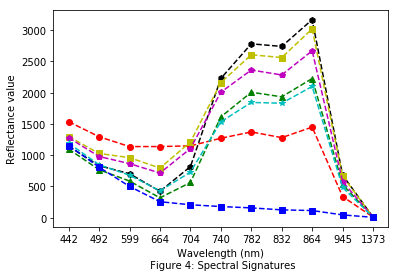

In [7]:
# Extract and display spectral signatures for the 7 classes
#spec_table2 = spec_table[0,:11,1:].T
#labels = spec_table[-1,1:].T
idx = sample_table

idx1 = np.average(idx[idx[:,-1]==1],axis=0)
idx2 = np.average(idx[idx[:,-1]==2],axis=0)
idx3 = np.average(idx[idx[:,-1]==3],axis=0)
idx4 = np.average(idx[idx[:,-1]==4],axis=0)
idx5 = np.average(idx[idx[:,-1]==5],axis=0)
idx6 = np.average(idx[idx[:,-1]==6],axis=0)
idx7 = np.average(idx[idx[:,-1]==7],axis=0)

bandnm = [442,492,599,664,704,740,782,832,864,945,1373]

plt.figure(4)#,figsize=(10,5))
plt.plot(idx1[:-1], '--ro', idx2[:-1], '--g^', idx3[:-1], '--kh', idx4[:-1], '--ys',
         idx5[:-1], '--mp', idx6[:-1], '--c*', idx7[:-1], '--bs')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10],[442,492,599,664,704,740,782,832,864,945,1373])
plt.xlabel('Wavelength (nm)\n Figure 4: Spectral Signatures')
plt.ylabel('Reflectance value')
plt.show()

#### 2.2.2 Data Processing
What data processing is done in the jupyter notebook before it can be placed in the classification algorithms.
- Extract a test and training set

Prepare the data by creating a table for the sample data then sperating into training set, testing set, and image classification set.

Divide the samples into train and test split at 33% which comes from research. Then at 50% to see if a larger test set would prevent accuracy overestimation [2].

The 10m resolusion GeoTiff is massive and requires segmentation in order to run the prediction models using scikit-learn. If this is not done then memory is depleted, and results require hours of time.

In [8]:
# Extract Y_train and X_train from table
ln, wd = sample_table.shape
X = sample_table[:,0:wd-1]
Y = sample_table[:,-1]

X_train, X_test,Y_train, Y_test = train_test_split(X, Y, test_size=0.30)

print('Testing and training set shape:')
print(X_test.shape)
print(X_train.shape)
print(Y_test.shape)
print(Y_train.shape)

print('Image to be classified shape:')
image_class = S2_image.reshape(l*w,num_bands)
print(image_class.shape)

# Divide data into to 4 for faster processing
datLen,fields = image_class.shape 
qt = int(datLen/4)
image_classAa = image_class[:qt,:]
image_classAb = image_class[qt:qt*2,:]
image_classBa = image_class[qt*2:qt*3,:]
image_classBb = image_class[qt*3:,:]

Testing and training set shape:
(18985, 11)
(44296, 11)
(18985,)
(44296,)
Image to be classified shape:
(28896685, 11)


### 2.2 Classification Methods
#### 2.2.1 Process data and create base classification for comparison
The data was delivered as a level 1C product which means that system processing has been completed. The dataset contains top of the atmosphere returns which require an atmospheric correction. 
- Explain what an atmospheric correction is and why it is required

Prior to preforming a land classificaton the data was resampled to 10m using bilinear resampling, then a subset was chosen for the study area.

- Explain the PCI software and why it will be used as the base case classification model, how it works, etc.


In [9]:
# Load data required for accuracy assessment and visualization


#### 2.2.2 Recreate Maximum Likelihood Classification
Using a Gaussian distribution.

In [10]:
# Maximum Likelihood Classifier
mle_start = time.time()

mle = GaussianNB()

# Fit the classifier on the training dataset
mle.fit(X_train, Y_train)

mle_fit_t = time.time()

# Predict the classification for each pixel in image
mle_Y_predAa = mle.predict(image_classAa)
mle_Y_predAb = mle.predict(image_classAb)
mle_Y_predBa = mle.predict(image_classBa)
mle_Y_predBb = mle.predict(image_classBb)

mle_pred_t = time.time()

# Check shape of output and reshape to display image
mle_Y_whole = np.append(mle_Y_predAa,mle_Y_predAb)
mle_Y_whole = np.append(mle_Y_whole,mle_Y_predBa)
mle_Y_whole = np.append(mle_Y_whole,mle_Y_predBb)
mle_img = mle_Y_whole.reshape(l,w)

# Print the score using the test set data
mle_score = mle.score(X_test,Y_test)

#### 2.2.3 Support Vector Machine
- What is a support vector machine

There are various types: linear, polynomial, and rbf.
- explain the differences

The different types of kernels for the SVM was analyzed for accuracy and one chosen to compare to the PCI software output.


In [11]:
# SVC - support vector classification
# LINEAR Kernel Test
svc_start = time.time()

svc = svm.SVC(kernel = 'linear', C = .3) 

# Fit the classifier on the training dataset
svc.fit(X_train, Y_train)

svc_fit_t = time.time()

# Predict the classification for each pixel in image
svc_Y_predAa = svc.predict(image_classAa)
svc_Y_predAb = svc.predict(image_classAb)
svc_Y_predBa = svc.predict(image_classBa)
svc_Y_predBb = svc.predict(image_classBb)

svc_pred_t = time.time()

# Check shape of output and reshape to display image
svc_Y_whole = np.append(svc_Y_predAa,svc_Y_predAb)
svc_Y_whole = np.append(svc_Y_whole,svc_Y_predBa)
svc_Y_whole = np.append(svc_Y_whole,svc_Y_predBb)
svc_img = svc_Y_whole.reshape(l,w)

# Print the score using the test set data
svc_score = svc.score(X_test,Y_test)

In [12]:
# !! TRY SCALING DATA !!!
C = 0.3 # regularization parameter - try varying these values
gamma = 5

poly_start_t = time.time()

poly = svm.SVC(kernel="poly", gamma=gamma, degree=3, C=C)

poly.fit(X_train, Y_train)

poly_fit_t = time.time()

# Predict the classification for each pixel in image
poly_Y_predAa = poly.predict(image_classAa)
poly_Y_predAb = poly.predict(image_classAb)
poly_Y_predBa = poly.predict(image_classBa)
poly_Y_predBb = poly.predict(image_classBb)

poly_pred_t = time.time()

# Check shape of output and reshape to display image
poly_Y_whole = np.append(poly_Y_predAa,poly_Y_predAb)
poly_Y_whole = np.append(poly_Y_whole,poly_Y_predBa)
poly_Y_whole = np.append(poly_Y_whole,poly_Y_predBb)
poly_img = poly_Y_whole.reshape(l,w)

# Print the score using the test set data
poly_score = poly.score(X_test,Y_test)

In [ ]:
# TRIED RBF WITH ONLY A QUARTER OF THE IMAGE TO CLASSIFY, BUT STILL TOOK HOURS TO COMPLETE 
# (THE TIME BELOW IS NOT ACCURATE IT WAS CLOSER TO 2.5 HOURS OR MORE)
# Tried with default parameters and had no ouput - took more than 12 hours.
# Tried with small C and Gamma - only have 2 wrong classes - took 2 hours
# Tried with C=0.3 and gamma = 5 - took less than 1 hour to train, but >10 hours total to predict
# REMOVE THIS KERNEL FROM CONSIDERATION
# Try different models and print output
C = 0.3 # regularization parameter - try varying these values
gamma = 5
svc_start = time.time()
print('Start')
# Fit the classifier on the training dataset
clf_rbf = svm.SVC(kernel="rbf", C=C, gamma=gamma)
print('Create SVC')
clf_rbf.fit(X_train,Y_train)
print('Fit SVC')
svc_fit_t = time.time()
print('Start Predict')
# Predict the classification for each pixel in image
rbf_Y_predAa = clf_rbf.predict(image_classAa)
rbf_Y_predAb = clf_rbf.predict(image_classAb)
rbf_Y_predBa = clf_rbf.predict(image_classBa)
rbf_Y_predBb = clf_rbf.predict(image_classBb)
print('End Predict')
svc_pred_t = time.time()
print('Getting Score')
score_rbf = clf_rbf.score(X_test, Y_test)

# Check shape of output and reshape to display image
rbf_Y_whole = np.append(rbf_Y_predAa,rbf_Y_predAb)
rbf_Y_whole = np.append(rbf_Y_whole,rbf_Y_predBa)
rbf_Y_whole = np.append(rbf_Y_whole,rbf_Y_predBb)
rbf_img = rbf_Y_whole.reshape(l,w)

plt.figure(1)
plt.imshow(rbf_img)

Start
Create SVC
Fit SVC
Start Predict


#### 2.2.4 Neural Network
One node for each band plus the x and y location.
Consider the multilayer perceptron.

In [14]:
# Neural Network from scikit - learn

nn_start = time.time()

nn = MLPClassifier(hidden_layer_sizes=(23,), activation='tanh')

# Fit the classifier on the training dataset
nn.fit(X_train, Y_train)

nn_fit_t = time.time()

# Predict the classification for each pixel in image
nn_Y_predAa = nn.predict(image_classAa)
nn_Y_predAb = nn.predict(image_classAb)
nn_Y_predBa = nn.predict(image_classBa)
nn_Y_predBb = nn.predict(image_classBb)

nn_pred_t = time.time()

nn_Y_whole = np.append(nn_Y_predAa,nn_Y_predAb)
nn_Y_whole = np.append(nn_Y_whole,nn_Y_predBa)
nn_Y_whole = np.append(nn_Y_whole,nn_Y_predBb)
nn_img = nn_Y_whole.reshape(l,w)

nn_score = nn.score(X_test,Y_test)

#### 2.2.5 Time and Space Efficiency
Each machine learning algorithm tested was timed to determine the time effeciency. The space effiecency for each algorthm will also be analyzed.

#### 2.2.6 Accuracy Assessment 
There are various accuracy tests that were conducted. The first is a built in accuracy score determined with the scikit learn library score() function which takes in a test set of training sites where the classification is known and compares them to the algorithm's actual output. The number of training pixels set aside for testing was 400 and they were determined with random selection. 

The second accuracy test conducted was a confusion matrix.
- explain indepth

Also include the following accuracy tests with in depth descriptions:

- kappa score, precision, recall, f measure, stratified cross validation mean accuracy score

- Producer's and User's accruacy for each algorithm

These determinants along with the time and space efficiency will be considered. A weighting of each determinate could be applied to give each algorithm a quantitative score. This has yet to be determined but may look something like:

0.70 * accuracy + 0.15 time efficiency + 0.15 space efficiency = algorithm score

As there are many other factors to consider beyond this scoring method it will aid in a final decision but each algorithm will be looked at in depth. For example, to determine which algorithm may classify one land type better than another.

CONSIDER THE ACCURACY ASSESMENT FOR PCI MLE

In [15]:
# Calculate and save the accuracy values here to display in results

# Calculate the confusion matrix for each classification method and display side by side
mle_test = mle.predict(X_test)
svc_test = svc.predict(X_test)
nn_test = nn.predict(X_test)
# MLE confusion matrix
mle_con_mx = confusion_matrix(Y_test, mle_test)
# SVC confusion matrix
svc_con_mx = confusion_matrix(Y_test, svc_test)
# Neural network confusion matrix
nn_con_mx = confusion_matrix(Y_test, nn_test)

# Calculate accuracy score based on (diagonal /total samples)
mle_diag = np.diag(mle_con_mx)
svc_diag = np.diag(svc_con_mx)
nn_diag = np.diag(svc_con_mx)
            
acc_mle = np.sum(mle_diag)/np.sum(mle_con_mx)
acc_svc = np.sum(svc_diag)/np.sum(svc_con_mx)
acc_nn = np.sum(nn_diag)/np.sum(nn_con_mx)

# Calculate the Producer's (column) and User's (row) Accuracy for each class
mle_prod = mle_diag*(1/np.sum(mle_con_mx[:,-1]))*100
mle_user = mle_diag*(1/np.sum(mle_con_mx[-1,:]))*100
svc_prod = mle_diag*(1/np.sum(svc_con_mx[:,-1]))*100
svc_user = mle_diag*(1/np.sum(svc_con_mx[-1,:]))*100
nn_prod = mle_diag*(1/np.sum(nn_con_mx[:,-1]))*100
nn_user = mle_diag*(1/np.sum(nn_con_mx[-1,:]))*100

# Calculate F-measure, precision, and recall 
p_mle, r_mle, f_mle, s_mle = precision_recall_fscore_support(Y_test,mle_test)
p_mle,r_mle,f_mle = p_mle.round(decimals = 6),r_mle.round(decimals = 6),f_mle.round(decimals = 6)
p_svc, r_svc, f_svc, s_svc = precision_recall_fscore_support(Y_test,svc_test)
p_svc,r_svc,f_svc = p_svc.round(decimals = 6),r_svc.round(decimals = 6),f_svc.round(decimals = 6)
p_nn, r_nn, f_nn, s_nn = precision_recall_fscore_support(Y_test,nn_test)
p_nn,r_nn,f_nn = p_nn.round(decimals = 6),r_nn.round(decimals = 6),f_nn.round(decimals = 6)

# Perform stratified k-fold cross validation

# from https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression
def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z
'''
# Perform Stratified k-fold cross validation
shuffle = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scoring = ['precision_macro','recall_macro','accuracy','f1_macro']
scores_mle_all, scores_svc_all, scores_nn_all = {},{},{}
skf = StratifiedKFold(n_splits=5)
for train, test in skf.split(X, Y):
    scores_mle = cross_validate(mle, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  
    scores_mle_all = merge_two_dicts(scores_mle_all, scores_mle)
    scores_svc = cross_validate(svc, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  
    scores_svc_all = merge_two_dicts(scores_svc_all, scores_svc)
    scores_nn = cross_validate(nn, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  
    scores_nn_all = merge_two_dicts(scores_nn_all, scores_nn)
    '''

C:\Users\andre\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


"\n# Perform Stratified k-fold cross validation\nshuffle = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)\nscoring = ['precision_macro','recall_macro','accuracy','f1_macro']\nscores_mle_all, scores_svc_all, scores_nn_all = {},{},{}\nskf = StratifiedKFold(n_splits=5)\nfor train, test in skf.split(X, Y):\n    scores_mle = cross_validate(mle, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  \n    scores_mle_all = merge_two_dicts(scores_mle_all, scores_mle)\n    scores_svc = cross_validate(svc, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  \n    scores_svc_all = merge_two_dicts(scores_svc_all, scores_svc)\n    scores_nn = cross_validate(nn, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  \n    scores_nn_all = merge_two_dicts(scores_nn_all, scores_nn)\n    "

In [16]:
# Import the PCI MLE confusion matrix and other text reports
# Extract accuracy assessment values

#### 2.2.7 Statistical Comparison between Algorithms and to base
The pixel by pixel differece was compared and then a root mean square error and r-square value were determined for each scene.
- explain why and what thesea are

The number of correcly classified pixels will be divided by the the total number of pixels to gather a percentage of correctly classified pixels. As the PCI classification output may not be 100% if these values are >70% that will be considered good.

In [17]:
# Create Contingency Table from confusion matrices

#PCI MLE vs MLE

#PCI MLE vs SVC

#PCI MLE vs NN

# MLE vs SVC
'''
ms_TP = np.minimum(mle_diag,svc_diag)
ms_FP, ms_FN, ms_TN = 0,0,0
for ms in range(-6,6,1):
    t1 = np.trace(mle_con_mx,ms)
    t2 = np.trace(svc_con_mx,ms)
    for ms1,ms2 in zip(t1,t2):
        if ms1 == ms2:
            TN+=ms1
        if ms1>ms2
        
'''

# MLE vs NN
mn_tp=np.minimum(mle_diag,nn_diag)
#print(mn_tp)

# SVC vs NN
sn_tp=np.minimum(svc_diag,nn_diag)
#print(sn_tp)

'''
# Use this loop for McNemar comparison?? CHANGE PARAMETERS
cor_mle, cor_svc, cor_nn = 0,0,0
for i in range(l):
    for j in range(w):   
        cl = sites[i,j]
        if cl>0:
            if mle_img[i,j] == cl:
                cor_mle += 1
            if svc_img[i,j] == cl:
                cor_svc += 1
            if nn_img[i,j] == cl:
                cor_nn += 1
                '''

'\n# Use this loop for McNemar comparison?? CHANGE PARAMETERS\ncor_mle, cor_svc, cor_nn = 0,0,0\nfor i in range(l):\n    for j in range(w):   \n        cl = sites[i,j]\n        if cl>0:\n            if mle_img[i,j] == cl:\n                cor_mle += 1\n            if svc_img[i,j] == cl:\n                cor_svc += 1\n            if nn_img[i,j] == cl:\n                cor_nn += 1\n                '

## 3. Results
### 3.1 Descriptive Statistics
Descriptive statistics for each spectral band from the dataset

In [18]:
# Print descriptive statistics for each band
numB = 0
for numB in range(0,12):
    print("Band #%d: Minimum=%.3f, Maximum=%.3f, Mean=%.3f, Standard Deviation=%.3f"%(numB+1,stats_all[numB,0],
                                                                                      stats_all[numB,1], 
                                                                                      stats_all[numB,2],
                                                                                      stats_all[numB,3]))
    numB += 1

Band #1: Minimum=0.000, Maximum=0.000, Mean=339.743, Standard Deviation=266.817
Band #2: Minimum=1008.000, Maximum=2573.000, Mean=1160.923, Standard Deviation=78.239
Band #3: Minimum=656.000, Maximum=6087.000, Mean=832.732, Standard Deviation=111.000
Band #4: Minimum=393.000, Maximum=5761.000, Mean=597.282, Standard Deviation=158.194
Band #5: Minimum=198.000, Maximum=7323.000, Mean=365.727, Standard Deviation=197.341
Band #6: Minimum=157.000, Maximum=6220.000, Mean=483.101, Standard Deviation=301.141
Band #7: Minimum=121.000, Maximum=6526.000, Mean=978.969, Standard Deviation=790.413
Band #8: Minimum=119.000, Maximum=6788.000, Mean=1169.910, Standard Deviation=1002.647
Band #9: Minimum=86.000, Maximum=7795.000, Mean=1122.960, Standard Deviation=1021.890
Band #10: Minimum=71.000, Maximum=7501.000, Mean=1284.588, Standard Deviation=1155.643
Band #11: Minimum=29.000, Maximum=1701.000, Mean=303.167, Standard Deviation=252.365
Band #12: Minimum=1.000, Maximum=21.000, Mean=5.583, Standard De

### 3.2 Land Classification Output

- Use this section to display all the maps side by side
- Display accuracy results side by side
- Display confusion matrices
- Kappa scores
- Producers and User's accuracy 

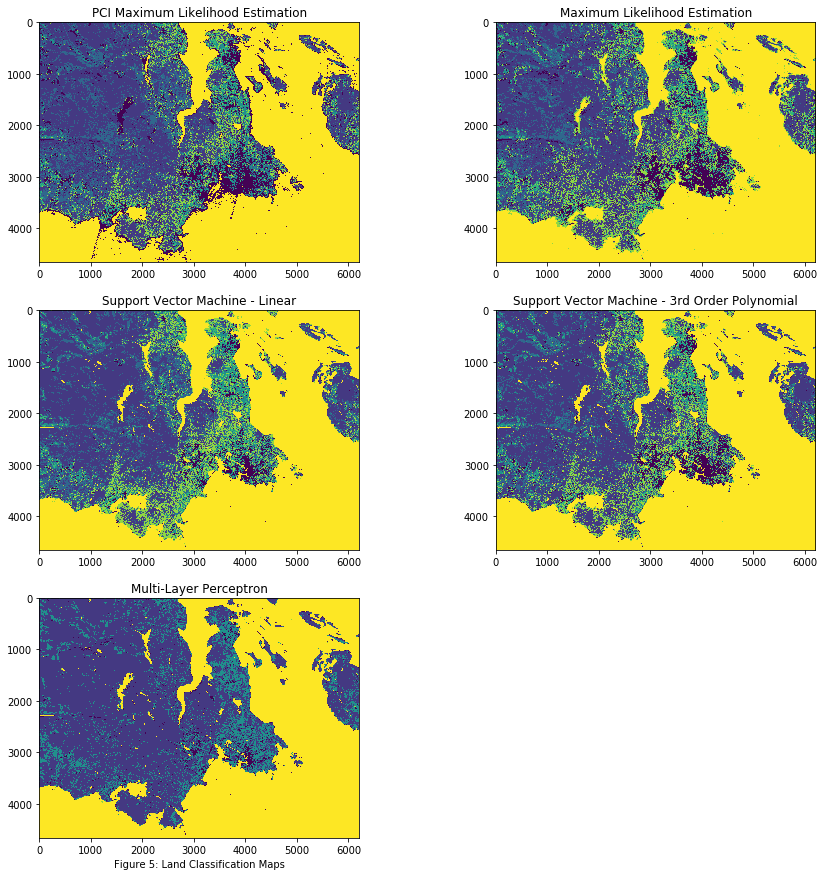

In [19]:
# Display all land classification maps considered

plt.figure(5, figsize=(15,15))
plt.subplot(321)
plt.title('PCI Maximum Likelihood Estimation')
plt.imshow(MLE_image)

plt.subplot(322)
plt.title('Maximum Likelihood Estimation')
plt.imshow(mle_img)

plt.subplot(323)
plt.title('Support Vector Machine - Linear')
plt.imshow(svc_img)

plt.subplot(324)
plt.title('Support Vector Machine - 3rd Order Polynomial')
plt.imshow(poly_img)

plt.subplot(325)
plt.title('Multi-Layer Perceptron')
plt.xlabel('Figure 5: Land Classification Maps')
plt.imshow(nn_img)

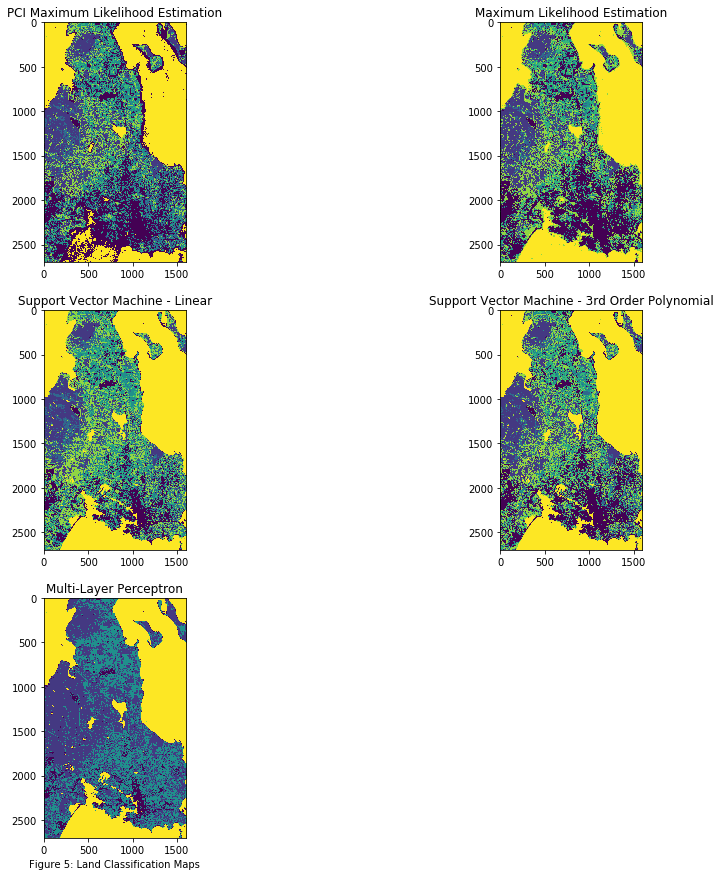

In [20]:
# Display zoomed in section of the pennisula
plt.figure(6, figsize=(15,15))
plt.subplot(321)
plt.title('PCI Maximum Likelihood Estimation')
plt.imshow(MLE_image[800:3500,3000:4600])

plt.subplot(322)
plt.title('Maximum Likelihood Estimation')
plt.imshow(mle_img[800:3500,3000:4600])

plt.subplot(323)
plt.title('Support Vector Machine - Linear')
plt.imshow(svc_img[800:3500,3000:4600])

plt.subplot(324)
plt.title('Support Vector Machine - 3rd Order Polynomial')
plt.imshow(poly_img[800:3500,3000:4600])

plt.subplot(325)
plt.title('Multi-Layer Perceptron')
plt.xlabel('Figure 5: Land Classification Maps')
plt.imshow(nn_img[800:3500,3000:4600])

## 3.3 Maximum Likelihood Classification Accuracy
Using the gaussian distribution for MLE and default paramters is good, will continue to refine this and reduce the gap between the PCI output and this.

In [21]:
# Calculate time efficiency for MLE
print('The time it took to fit the classification model with the training data: %.6f seconds'%(mle_fit_t-mle_start))
print('The time it took to predict the image classification matrix: %.6f seconds'%(mle_pred_t-mle_fit_t))
print('The time it took to run the classification method: %.6f seconds'%(mle_pred_t-mle_start))
print('The number of classes in this image: %s'%(np.unique(mle_Y_whole)))

The time it took to fit the classification model with the training data: 0.046870 seconds
The time it took to predict the image classification matrix: 38.021876 seconds
The time it took to run the classification method: 38.068746 seconds
The number of classes in this image: [1 2 3 4 5 6 7]


## 3.3 Support Vector Machine Accuracy
Trying different kernel types, and regularization parameter (C):
LINEAR kernel works well with C = 0.3.
RBF kernel does not work at all (just continues running for over an hour even after assigning max_iter). Will attempt to change parameters to correct this as research shows it is a common kernel type for land classification models [2].
POLYNOMIAL kernels work well, but wish to improve based on order and regularization parameter.
Moving forward in the accuracy assessment LINEAR kernel is currently being used as a comparison.

In [22]:
# Calculate time efficiency for SVC
print('The time it took to fit the SVC classification model with the training data: %.6f seconds'%(svc_fit_t-svc_start))
print('The time it took to predict the image classification matrix: %.6f seconds'%(svc_pred_t-svc_fit_t))
print('The time it took to run the SVC classification method: %.6f seconds'%(svc_pred_t-svc_start))
print('The number of classes in this image: %s'%(np.unique(svc_Y_whole)))

The time it took to fit the SVC classification model with the training data: 819.067753 seconds
The time it took to predict the image classification matrix: 67787.682575 seconds
The time it took to run the SVC classification method: 68606.750328 seconds
The number of classes in this image: [1 2 3 4 5 6 7]


In [23]:
print('the SVC 3rd Order Polynomial method accuracy score %.6f'%(poly_score))

# Calculate time efficiency for SVC
print('The time it took to fit the SVC classification model with the training data: %.6f seconds'%(poly_fit_t-poly_start_t))
print('The time it took to predict the image classification matrix: %.6f seconds'%(poly_pred_t-poly_fit_t))
print('The time it took to run the SVC classification method: %.6f seconds'%(poly_pred_t-poly_start_t))

print('The number of classes in this image: %s'%(np.unique(poly_Y_whole)))

the SVC 3rd Order Polynomial method accuracy score 0.998472
The time it took to fit the SVC classification model with the training data: 63.991838 seconds
The time it took to predict the image classification matrix: 128.031254 seconds
The time it took to run the SVC classification method: 192.023092 seconds
The number of classes in this image: [1 2 3 4 5 6 7]



## 3.4 Neural Network Accuracy
Trying different number of nodes within a single hidden layer with tanh activation based on research [3]:
- trial and error for number of nodes:
    - 14 underestimates the number of classes
    - 20 good overestimates shrub/urban
    - 25 97% overestimates water
    - 23 98% overestimates water
    - 24 97% overestimates shrub/urban
Try different activations to improve accuracy.

In [24]:
# Calculate time and space efficency for NN
print('The time it took to fit the NN classification model with the training data: %.6f seconds'%(nn_fit_t-nn_start))
print('The time it took to predict the image classification matrix: %.6f seconds'%(nn_pred_t-nn_fit_t))
print('The time it took to run the NN classification method: %.6f seconds'%(nn_pred_t-nn_start))
print('The number of classes in this image: %s'%(np.unique(nn_Y_whole)))

The time it took to fit the NN classification model with the training data: 5.402105 seconds
The time it took to predict the image classification matrix: 13.933201 seconds
The time it took to run the NN classification method: 19.335306 seconds
The number of classes in this image: [1 2 4 5 6 7]


## 3.5 Time and Space Complexity
NEED TO CALC STILL

### 3.5.1 Maximum Likelihood Classification


### 3.5.2 Support Vector Machine


### 3.5.3 Neural Network




## 3.6 Accuracy Assessment


- A confusion matrix will be used to compare each label and it's accuracy against misclassifications. 

- The precision and recall will be considered for each algorithm with an overall F-Measure and Accuracy Measure.

- The statistical difference between each algorithm's error rate within a given confidence interval (90% or 95%) - Kappa statistic/McNemar Test

- Producer's and User's accruacy for each algorithm

These determinants along with the time and space efficiency will be considered. A weighting of each determinate could be applied to give each algorithm a quantitative score. This has yet to be determined but may look something like:

0.70 * accuracy + 0.15 time efficiency + 0.15 space efficiency = algorithm score

As there are many other factors to consider beyond this scoring method it will aid in a final decision but each algorithm will be looked at in depth. For example, to determine which algorithm may classify one land type better than another.

CONSIDER THE ACCURACY ASSESMENT FOR PCI MLE

The accuracy score below was derived from the built in scoring function which is part of the scikit-learn library for each machine learning algorithm.

In [25]:
# Score function from scikit learn output based on X_test and Y_test data
print('MLE accuracy function score: %.6f'%(mle_score))
print('SVC accuracy function score: %.6f'%(svc_score))
print('NN accuracy function score: %.6f'%(nn_score))

MLE accuracy function score: 0.967659
SVC accuracy function score: 0.991783
NN accuracy function score: 0.951383


The accuracy score below is used to determine each algorithms accuracy against the ground truth layer:
accuracy = # correct predictions/ # instances

In [26]:
# Consider the accuracy calculation {accuracy = # correct predictions / # instances}
print('MLE accuracy score: %.6f'%(acc_mle))
print('SVC accuracy score: %.6f'%(acc_svc))
print('NN accuracy score: %.6f'%(acc_nn))

MLE accuracy score: 0.967659
SVC accuracy score: 0.991783
NN accuracy score: 0.991783


Maximum Likelihood Estimation
[[  692     0     0   100     0    28     0]
 [    0  2567   119     0     0     4     0]
 [    0     1   177     0    14    24     0]
 [  183     0     0   700    36     0     0]
 [   10     0    26    33   303     0     0]
 [    0     8    21     3     4    49     0]
 [    0     0     0     0     0     0 13883]]

Support Vector Classification - Linear
[[  794     0     0    26     0     0     0]
 [    0  2688     2     0     0     0     0]
 [    0     9   202     0     2     3     0]
 [   49     0     2   849    19     0     0]
 [    0     0     1    36   335     0     0]
 [    0     0     6     0     1    78     0]
 [    0     0     0     0     0     0 13883]]

Multi-Layer Perceptron
[[  660     1     0   159     0     0     0]
 [    0  2690     0     0     0     0     0]
 [    0   206     0    10     0     0     0]
 [    0    90     0   829     0     0     0]
 [    0    60     0   312     0     0     0]
 [   16    66     0     3     0     0     0]
 [  

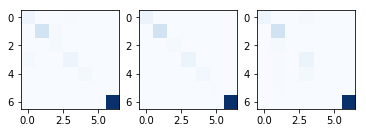

In [27]:
print('Maximum Likelihood Estimation')
print(mle_con_mx)
print()
    
i=1
plt.subplot(1, 3, i)
plt.imshow(mle_con_mx, cmap="Blues")

print('Support Vector Classification - Linear')
print(svc_con_mx)
print()
    
plt.subplot(1, 3, i+1)
plt.imshow(svc_con_mx, cmap="Blues")

print('Multi-Layer Perceptron')
print(nn_con_mx)
print()
    
plt.subplot(1, 3, i+2)
plt.imshow(nn_con_mx, cmap="Blues")

In [28]:
# Calculate Producer's and User's Accuracy from the confusion matrix
# Calculate accuracy score from confusion matrix

In [29]:
# Consider the F-Measure, recall, and precision

print('MLE Classifier - precision, recall, and F-Measure for each class')
print('%s\n%s\n%s\n'%(p_mle,r_mle,f_mle))
print('SVC Classifier - precision, recall, and F-Measure for each class')
print('%s\n%s\n%s\n'%(p_svc,r_svc,f_svc))
print('NN Classifier - precision, recall, and F-Measure for each class')
print('%s\n%s\n%s\n'%(p_nn,r_nn,f_nn))

MLE Classifier - precision, recall, and F-Measure for each class
[0.781921 0.996506 0.516035 0.837321 0.848739 0.466667 1.      ]
[0.843902 0.954275 0.819444 0.761697 0.814516 0.576471 1.      ]
[0.81173  0.974934 0.633274 0.797721 0.831276 0.515789 1.      ]

SVC Classifier - precision, recall, and F-Measure for each class
[0.941874 0.996663 0.948357 0.931943 0.938375 0.962963 1.      ]
[0.968293 0.999257 0.935185 0.92383  0.900538 0.917647 1.      ]
[0.954901 0.997958 0.941725 0.927869 0.919067 0.939759 1.      ]

NN Classifier - precision, recall, and F-Measure for each class
[0.976331 0.864118 0.       0.631379 0.       0.       1.      ]
[0.804878 1.       0.       0.902067 0.       0.       1.      ]
[0.882353 0.927107 0.       0.742832 0.       0.       1.      ]



In [30]:
# Dispaly cross validation data
#print(scores_all)
print(scores_mle_all.keys())
#print(scores['fit_time'])
#print(scores['score_time'])
#print(scores['test_precision_macro'])
#print(scores['train_precision_macro'])
#print(scores['test_recall_macro'])
#print(scores['train_recall_macro'])

NameError: name 'scores_mle_all' is not defined

In [ ]:
# Final quantitative value for each method
# Consider including the F-measure, recall, or precision as well
# 0.70 * accuracy + 0.15 time efficiency + 0.15 space efficiency = algorithm score

## 3.7 Comparison Between Algorithms and against PCI Maximum Likelihood Estimation

Consider the overall accuracy scores determined above, and perform the McNemar Test to get a statistical difference between each land classification map.

In [ ]:
# !!!! TEST!!!!
# McNemar Test using confustion matrix
import statsmodels
#stats, pval = mcnemar(mle_con_mx, svc_con_mx)
#stats,pval = statsmodels.sandbox.stats.runs.mcnemar(mle_con_mx, svc_con_mx)
stats,pval = statsmodels.stats.runs.mcnemar(mle_con_mx, svc_con_mx)

In [ ]:
from sklearn.metrics import r2_score
print('Comparison between PCI MLE and scikit-learn MLE')

# Try calculating the kappa score between the two maps based on the Y output
# for each one - instead of r square
# OR McNemar Test using the confusion matrices for each

# Calculate rmse
mle_diff = MLE_image - mle_img
plt.imshow(mle_diff)

sse = np.sum([x**2 for x in mle_diff])
rmse = np.sqrt((sse)/(l*w)) 
print('The rmse between PCI MLE and scikit-learn MLE is: %.6f'%(rmse))

# Calculate r-square
r2 = r2_score(MLE_image, mle_img)
print('The r-square between PCI MLE and scikit-learn MLE is: %.6f'%(r2))

In [ ]:
print('Comparison between PCI MLE and scikit-learn SVC')
# Calculate rmse
svc_diff = MLE_image - svc_img
plt.imshow(svc_diff)

sse = np.sum([x**2 for x in svc_diff])
rmse = np.sqrt((sse)/(l*w)) 
print('The rmse between PCI MLE and scikit-learn SVC is: %.6f'%(rmse))

# Calculate r-square
r2 = r2_score(MLE_image, svc_img)
print('The r-square between PCI MLE and scikit-learn SVC is: %.6f'%(r2))

In [ ]:
print('Comparison between PCI MLE and scikit-learn Neural Network')
# Calculate rmse
nn_diff=MLE_image - nn_img
plt.imshow(nn_diff)

sse = np.sum([x**2 for x in nn_diff])
rmse = np.sqrt((sse)/(l*w)) 
print('The rmse between PCI MLE and scikit-learn Neural Network is: %.6f'%(rmse))

# Calculate r-square
r2 = r2_score(MLE_image, nn_img)
print('The r-square between PCI MLE and scikit-learn Neural Network is: %.6f'%(r2))

## 4. Discussion



### 4.1 Hurdles and Limitations

Known ATCOR atmospheric correction did not work for the Sentinel 2A product due to the PCI software's inability to gather the metadata and atmospheric data contained within the product. For this reason an auxillary software product called Sen2Cor built for the Sentinal mission data was used, as this was unfamiliar various attempts at atmospheric correction were made to ensure that it was done correctly (Many different paramters to try).

Started with loops and list notation, but was able to use the power of numpy indexing to streamline and create more effecitve and efficient code.

## 5. References

[1] Noi, P.T. and Kappa, M., 2018: Comparison of Random Forest, k-Nearest Neighbor, and Support Vector Machine Classifiers for 
    Land Cover Classification Using Sentinel-2 Imagery, Sensors. DOI: 10.3390/s18010018

[2] J. He, J.R. Harris, M. Sawada & P. Behnia (2015) A comparison of classification algorithms using Landsat-7 and Landsat-8 
    data for mapping lithology in Canada’s Arctic, International Journal of Remote Sensing, 36:8, 2252-2276, DOI: 
    10.1080/01431161.2015.1035410 

[3] F. Sunar Erbek , C. Özkan & M. Taberner (2004) Comparison of maximum likelihood classification method with supervised 
    artificial neural network algorithms for land use activities , International Journal of Remote Sensing, 25:9, 1733-1748, 
    DOI: 10.1080/0143116031000150077 